The code below first sets up the codebase (taken from https://github.com/cwgoddard/OOD_ICL) and replicates figure 2A which varies the family of task distributions against the performance on out of context task distributions of varying degrees.

In [1]:
!git clone https://github.com/jermainelei/OOD_ICL.git

Cloning into 'OOD_ICL'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 58 (delta 24), reused 51 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 1.08 MiB | 23.10 MiB/s, done.
Resolving deltas: 100% (24/24), done.


/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Choose a folder in your Drive to store code, checkpoints, and figures
base_dir = "/content/drive/MyDrive/Jermaine_OOD_ICL_182"
#!mkdir -p "$base_dir"


Mounted at /content/drive


dataset_utils.py  eval_utils.py  train_linreg.py  transformer.py


In [3]:
# !pip install torch torchvision scipy matplotlib -q

import sys, numpy as np, torch, matplotlib.pyplot as plt

# Make src importable no matter where we are
sys.path.append('/content/OOD_ICL/src')

import train_linreg

In [4]:
%cd OOD_ICL/src

/content/OOD_ICL/src



-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

phis = [165]   # 15°, 30°, ..., 180°

all_losses_per_phi = []
delta_angles = None

for phi in phis:
    print(f"\n=== Training model for φ = {phi}° ===")

    model, loss_history, test_loss_history, angles, losses = train_linreg.train(
        device=device,
        noise_std=0.0,                        # σ² = 0
        angle=phi,                            # pretraining diversity φ
        gaussianize=False,                    # matches paper’s “unit norm” default
        checkpoint_dir=f"{base_dir}/checkpoints_phi{phi}/",
        output_dir=f"{base_dir}/outputs_sigma0/"
        # all other args are left at their script defaults
        # (seq_len, d_model, epochs, etc.)
    )

    # Collect cone falloff results
    losses = np.array(losses)

    if delta_angles is None:
        delta_angles = np.array(angles)       # list of δ’s (0,5,...,175)

    all_losses_per_phi.append(losses)

# Shape: (num_deltas, num_phis)
losses_by_delta_phi = np.stack(all_losses_per_phi, axis=1)
phi_array = np.array(phis)

print("phi_array shape:", phi_array.shape)
print("delta_angles shape:", delta_angles.shape)
print("losses_by_delta_phi shape:", losses_by_delta_phi.shape)

# Save to Drive so you never have to retrain just for plotting
np.save(f"{base_dir}/phi_array_sigma0.npy", phi_array)
np.save(f"{base_dir}/delta_angles_sigma0.npy", delta_angles)
np.save(f"{base_dir}/losses_by_delta_phi_sigma0.npy", losses_by_delta_phi)
print("\nSaved arrays to Drive under:", base_dir)

Using device: cuda

=== Training model for φ = 165° ===
Training on half-angle:  165
using flash attention
Epoch:  1
Epoch complete, time: 0.23141955534617106 minutes, loss: 1.0407956838607788, test loss: 0.9994983899593354
Epoch:  2
Epoch complete, time: 0.2064430276552836 minutes, loss: 1.014479398727417, test loss: 1.0001940870285033
Epoch:  3
Epoch complete, time: 0.21152408123016359 minutes, loss: 0.996740996837616, test loss: 0.9990148115158081
Epoch:  4
Epoch complete, time: 0.2052967151006063 minutes, loss: 1.0065659284591675, test loss: 1.0045424282550812
Epoch:  5
Epoch complete, time: 0.2045149326324463 minutes, loss: 1.0203845500946045, test loss: 1.004361082315445
Epoch:  6
Epoch complete, time: 0.2043877402941386 minutes, loss: 0.9810672402381897, test loss: 1.0021251165866851
Epoch:  7
Epoch complete, time: 0.20537928740183511 minutes, loss: 1.020786166191101, test loss: 0.9998670947551728
Epoch:  8
Epoch complete, time: 0.20498855113983155 minutes, loss: 0.9887287616729

In [ ]:
import os, glob, re
import numpy as np

out_dir = f"{base_dir}/outputs_sigma0"
print("Files in outputs_sigma0:", os.listdir(out_dir))

# Collect all losses_angle*.npy files
paths = sorted(glob.glob(os.path.join(out_dir, "losses_angle*_tasks*.npy")))
print("Found loss files:")
for p in paths:
    print("  ", os.path.basename(p))

phi_list = []
losses_list = []

for p in paths:
    fname = os.path.basename(p)
    m = re.match(r"losses_angle(\d+)_tasks(\d+)\.npy", fname)
    if m is None:
        continue
    phi = int(m.group(1))           # this is ϕ in degrees
    phi_list.append(phi)
    losses_list.append(np.load(p))  # shape: (num_deltas,)

phi_array = np.array(phi_list)
# sort by φ just in case
order = np.argsort(phi_array)
phi_array = phi_array[order]
losses_list = [losses_list[i] for i in order]

# Stack into (num_deltas, num_phis)
losses_by_delta_phi = np.stack(losses_list, axis=1)

# Rebuild δ angles: step is 5° and length is len of first loss vector
num_deltas = losses_by_delta_phi.shape[0]
delta_angles = np.arange(0, 5 * num_deltas, 5)

print("phi_array:", phi_array)
print("delta_angles:", delta_angles)
print("losses_by_delta_phi shape:", losses_by_delta_phi.shape)

# Save for future plotting (so next time you don’t even need this cell)
np.save(f"{base_dir}/phi_array_sigma0.npy", phi_array)
np.save(f"{base_dir}/delta_angles_sigma0.npy", delta_angles)
np.save(f"{base_dir}/losses_by_delta_phi_sigma0.npy", losses_by_delta_phi)

print("\nSaved aggregated arrays in:", base_dir)

Files in outputs_sigma0: ['interp_losses_angle15_tasks10.npy', 'interp_dmmse_angle15_tasks10.npy', 'losses_angle15_tasks10.npy', 'interp_losses_angle30_tasks10.npy', 'interp_dmmse_angle30_tasks10.npy', 'losses_angle30_tasks10.npy', 'interp_losses_angle45_tasks10.npy', 'interp_dmmse_angle45_tasks10.npy', 'losses_angle45_tasks10.npy', 'interp_losses_angle60_tasks10.npy', 'interp_dmmse_angle60_tasks10.npy', 'losses_angle60_tasks10.npy', 'interp_losses_angle75_tasks10.npy', 'interp_dmmse_angle75_tasks10.npy', 'losses_angle75_tasks10.npy', 'interp_losses_angle90_tasks10.npy', 'interp_dmmse_angle90_tasks10.npy', 'losses_angle90_tasks10.npy', 'interp_losses_angle105_tasks10.npy', 'interp_dmmse_angle105_tasks10.npy', 'losses_angle105_tasks10.npy', 'interp_losses_angle120_tasks10.npy', 'interp_dmmse_angle120_tasks10.npy', 'losses_angle120_tasks10.npy', 'interp_losses_angle135_tasks10.npy', 'interp_dmmse_angle135_tasks10.npy', 'losses_angle135_tasks10.npy', 'interp_losses_angle150_tasks10.npy', 

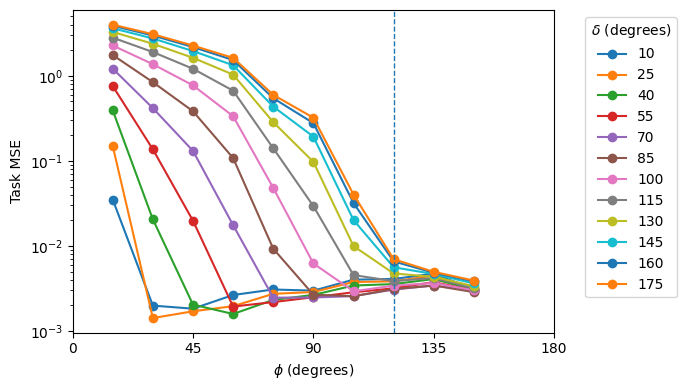

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# If you just finished training, you already have these in memory.
# Otherwise, load them from Drive:
phi_array = np.load(f"{base_dir}/phi_array_sigma0.npy")
delta_angles = np.load(f"{base_dir}/delta_angles_sigma0.npy")
losses_by_delta_phi = np.load(f"{base_dir}/losses_by_delta_phi_sigma0.npy")

# δ values to plot (as in the figure legend)
selected_deltas = np.array([10, 25, 40, 55, 70, 85, 100, 115, 130, 145, 160, 175])

# Find indices of these δs in delta_angles (which is 0,5,...,175)
delta_indices = [int(d // 5) for d in selected_deltas]  # because step is 5°

plt.figure(figsize=(7, 4))

for d, idx in zip(selected_deltas, delta_indices):
    mse_vs_phi = losses_by_delta_phi[idx]   # shape (num_phis,)
    plt.plot(phi_array, mse_vs_phi, marker='o', label=f"{int(d)}")

plt.yscale('log')
plt.xlabel(r"$\phi$ (degrees)")
plt.ylabel("Task MSE")

# Transition line around φ ≈ 120°
plt.axvline(120, linestyle="--", linewidth=1)

# Match x-axis ticks roughly to the paper
plt.xticks([0, 45, 90, 135, 180])

# Legend on the right, like the figure
plt.legend(title=r"$\delta$ (degrees)", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
fig_path = f"{base_dir}/fig2A_sigma0.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print("Saved figure to:", fig_path)

Saved figure to: /content/drive/MyDrive/OOD_ICL/fig2A_sigma0.png


<Figure size 640x480 with 0 Axes>

Now, below will include additions to the original codebase to explore our premise: how does task similarity generalize when we have a low rank task in a higher dimensional space. The process is the same as before but now our task space is sampled from a projected space, and we would like to test (1) how well can the transformer generalize to out-of-manifold tasks and (2) in-the-manifold tasks. We essentially are adding another layer of complexity to the original paper and combining it with the premise of this one: https://www.arxiv.org/pdf/2510.04548 (Learning Low-rank tasks in Context). The following changes were made: Add additionall functions to dataset_utils.py to include a sampling function that samples a subspace that was formed via projection from a higher dimensional space, and edit train to include intrinsic dimension as another parameter and define the samples accordingly.

In [ ]:
# Reload code after changing the files

import sys, importlib, torch, numpy as np

sys.path.append('/content/drive/MyDrive/OOD_ICL/OOD_ICL-main/src')

import dataset_utils, eval_utils, train_linreg
importlib.reload(dataset_utils)
importlib.reload(eval_utils)
importlib.reload(train_linreg)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [ ]:
# Perform sweep again like above BUT this time with low rank

import numpy as np
import os, glob, re

intrinsic_dim = 5          # ← the only k we’re running
phis = list(range(15, 181, 15))   # 15°, 30°, ..., 180°

pretrain_size = 2**10      # default in train_linreg
task_id = int(np.log2(pretrain_size))  # used in filenames (tasks10)

print(f"Running experiments for intrinsic_dim = {intrinsic_dim}")

all_losses_off_per_phi = []   # off-manifold (full sphere)
all_losses_on_per_phi  = []   # on-manifold (same subspace)
delta_angles = None

out_dir_k  = f"{base_dir}/outputs_sigma0_k{intrinsic_dim}"
ckpt_dir_k = f"{base_dir}/checkpoints_k{intrinsic_dim}"
os.makedirs(out_dir_k, exist_ok=True)
os.makedirs(ckpt_dir_k, exist_ok=True)

for phi in phis:
    print(f"\n=== Training model for φ = {phi}°, intrinsic_dim = {intrinsic_dim} ===")

    # train_linreg.train returns OFF-manifold angles & losses
    model, loss_history, test_loss_history, angles_off, losses_off = train_linreg.train(
        device=device,
        noise_std=0.0,                        # σ² = 0
        angle=phi,                            # pretraining diversity φ (degrees)
        gaussianize=False,                    # unit-norm setup
        checkpoint_dir=f"{ckpt_dir_k}/phi{phi}/",
        output_dir=f"{out_dir_k}/",
        intrinsic_dim=intrinsic_dim,          # ← low-rank manifold
        pretrain_size=pretrain_size
        # other args left at defaults (dim=10, epochs=120, etc.)
    )

    losses_off = np.array(losses_off)

    # ON-manifold losses were saved by train_linreg as:
    #   outputs_sigma0_k5/losses_manifold_angle{phi}_tasks{task_id}.npy
    manifold_path = os.path.join(
        out_dir_k,
        f"losses_manifold_angle{phi}_tasks{task_id}.npy"
    )
    losses_on = np.load(manifold_path)

    if delta_angles is None:
        delta_angles = np.array(angles_off)   # e.g. 0, 5, ..., 175

    all_losses_off_per_phi.append(losses_off)
    all_losses_on_per_phi.append(losses_on)

# Stack to shape (num_deltas, num_phis)
losses_off_by_delta_phi = np.stack(all_losses_off_per_phi, axis=1)
losses_on_by_delta_phi  = np.stack(all_losses_on_per_phi,  axis=1)
phi_array = np.array(phis)

print("phi_array shape:", phi_array.shape)
print("delta_angles shape:", delta_angles.shape)
print("losses_off_by_delta_phi shape:", losses_off_by_delta_phi.shape)
print("losses_on_by_delta_phi shape:",  losses_on_by_delta_phi.shape)

# Save k=5 arrays in base_dir (NOT overwriting your original baseline)
np.save(f"{base_dir}/phi_array_sigma0_k{intrinsic_dim}.npy", phi_array)
np.save(f"{base_dir}/delta_angles_sigma0_k{intrinsic_dim}.npy", delta_angles)
np.save(f"{base_dir}/losses_off_by_delta_phi_sigma0_k{intrinsic_dim}.npy", losses_off_by_delta_phi)
np.save(f"{base_dir}/losses_on_by_delta_phi_sigma0_k{intrinsic_dim}.npy",  losses_on_by_delta_phi)

print(f"\nSaved aggregated arrays for k={intrinsic_dim} to:", base_dir)

Running experiments for intrinsic_dim = 5

=== Training model for φ = 15°, intrinsic_dim = 5 ===
Training on half-angle:  15
using flash attention
Epoch:  1
Epoch complete, time: 0.36674155791600543 minutes, loss: 0.04776274412870407, test loss: 1.9520675039291382
Epoch:  2
Epoch complete, time: 0.339384651184082 minutes, loss: 0.04761751368641853, test loss: 1.9307076740264892
Epoch:  3
Epoch complete, time: 0.34328585068384804 minutes, loss: 0.04903892055153847, test loss: 1.953911108970642
Epoch:  4
Epoch complete, time: 0.3389848510424296 minutes, loss: 0.04669236019253731, test loss: 1.9822603726387025
Epoch:  5
Epoch complete, time: 0.3409299850463867 minutes, loss: 0.04572276026010513, test loss: 1.8619133305549622
Epoch:  6
Epoch complete, time: 0.3417339126269023 minutes, loss: 0.04577161371707916, test loss: 1.921299273967743
Epoch:  7
Epoch complete, time: 0.34652425050735475 minutes, loss: 0.04569612443447113, test loss: 1.96244206905365
Epoch:  8
Epoch complete, time: 0.34

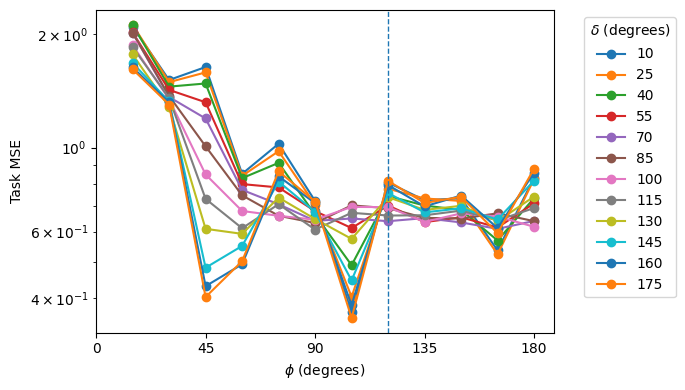

Saved figure to: /content/drive/MyDrive/OOD_ICL/fig_off_manifold_sigma0_k5.png


In [ ]:
# Plot new graphics - off manifold
import numpy as np
import matplotlib.pyplot as plt

k = 5

phi_array = np.load(f"{base_dir}/phi_array_sigma0_k{k}.npy")
delta_angles = np.load(f"{base_dir}/delta_angles_sigma0_k{k}.npy")
losses_off_by_delta_phi = np.load(f"{base_dir}/losses_off_by_delta_phi_sigma0_k{k}.npy")

selected_deltas = np.array([10, 25, 40, 55, 70, 85, 100, 115, 130, 145, 160, 175])
delta_indices = [int(d // 5) for d in selected_deltas]

plt.figure(figsize=(7, 4))

for d, idx in zip(selected_deltas, delta_indices):
    mse_vs_phi = losses_off_by_delta_phi[idx]   # shape (num_phis,)
    plt.plot(phi_array, mse_vs_phi, marker='o', label=f"{int(d)}")

plt.yscale('log')
plt.xlabel(r"$\phi$ (degrees)")
plt.ylabel("Task MSE")
plt.axvline(120, linestyle="--", linewidth=1)
plt.xticks([0, 45, 90, 135, 180])
plt.legend(title=r"$\delta$ (degrees)", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

fig_path = f"{base_dir}/fig_off_manifold_sigma0_k{k}.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()
print("Saved figure to:", fig_path)

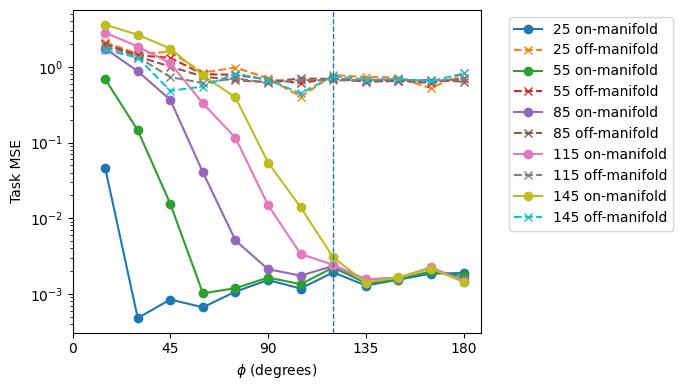

Saved figure to: /content/drive/MyDrive/OOD_ICL/fig_on_vs_off_sigma0_k5.png


In [ ]:
# Plotting new graphics - on manifold

import numpy as np
import matplotlib.pyplot as plt

k = 5

phi_array = np.load(f"{base_dir}/phi_array_sigma0_k{k}.npy")
delta_angles = np.load(f"{base_dir}/delta_angles_sigma0_k{k}.npy")
losses_off_by_delta_phi = np.load(f"{base_dir}/losses_off_by_delta_phi_sigma0_k{k}.npy")
losses_on_by_delta_phi  = np.load(f"{base_dir}/losses_on_by_delta_phi_sigma0_k{k}.npy")

# Use fewer δs so the plot isn’t too cluttered
selected_deltas = np.array([25, 55, 85, 115, 145])
delta_indices = [int(d // 5) for d in selected_deltas]

plt.figure(figsize=(7, 4))

for d, idx in zip(selected_deltas, delta_indices):
    mse_on  = losses_on_by_delta_phi[idx]
    mse_off = losses_off_by_delta_phi[idx]

    plt.plot(phi_array, mse_on,  marker='o', label=f"{int(d)} on-manifold")
    plt.plot(phi_array, mse_off, linestyle='--', marker='x', label=f"{int(d)} off-manifold")

plt.yscale('log')
plt.xlabel(r"$\phi$ (degrees)")
plt.ylabel("Task MSE")
plt.axvline(120, linestyle="--", linewidth=1)
plt.xticks([0, 45, 90, 135, 180])
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

fig_path = f"{base_dir}/fig_on_vs_off_sigma0_k{k}.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()
print("Saved figure to:", fig_path)

In [ ]:
# Train sweeps: dim=10, ks={8,9}, c in {1,2,4,10}
results_dir = "/content/drive/MyDrive/Jermaine_OOD_ICL_182"
import os, sys, time, torch
sys.path.append(os.path.join(os.getcwd(), "src"))

import train_linreg

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

dim = 10
ks = [5,3]            # change here if you want different k values
c_values = [64]

# Training hyperparams
batch_size = 128
lr = 3e-4
epochs = 120
batches_per_epoch = 100
seq_len = 50
d_model = 128
n_layer = 10
noise_std = 0.0
pretrain_size = 2**10
angle_deg = 180
gaussianize = False
lr_milestones = []

mse_by_k = {}  # {k: {c: final_test_mse}}
for k in ks:
    mse_by_k[k] = {}
    for c in c_values:
        ckpt_dir = f"{results_dir}/checkpoints/d{dim}_k{k}_c{c}/"
        out_dir  = f"{results_dir}/output/d{dim}_k{k}_c{c}/"
        print(f"\n=== Training: dim={dim}, k={k}, c={c} ===")
        t0 = time.time()
        _, _, test_loss_hist, _, _ = train_linreg.train(
            batch_size=batch_size,
            lr=lr,
            epochs=epochs,
            batches_per_epoch=batches_per_epoch,
            device=device,
            seq_len=seq_len,
            d_model=d_model,
            n_layer=n_layer,
            dim=dim,
            noise_std=noise_std,
            c=c,
            checkpoint_dir=ckpt_dir,
            pretrain_size=pretrain_size,
            angle=angle_deg,      # degrees -> radians inside train()
            lr_milestones=lr_milestones,
            gaussianize=gaussianize,
            save_freq=3,
            output_dir=out_dir,
            intrinsic_dim=k
        )
        final_mse = float(test_loss_hist[-1])
        mse_by_k[k][c] = final_mse
        print(f"Done in {(time.time()-t0)/60:.2f} min | final test MSE: {final_mse:.6f}")

print("\nCollected MSEs:", mse_by_k)

ModuleNotFoundError: No module named 'train_linreg'

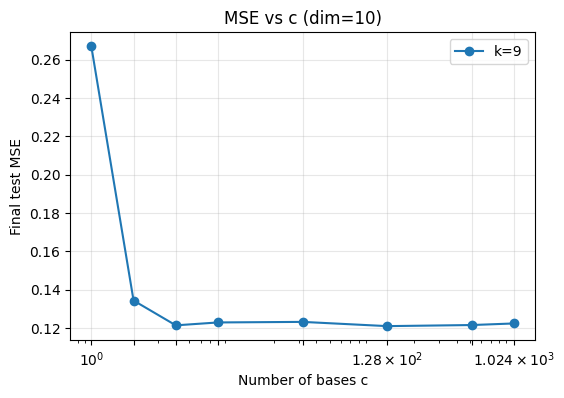

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
results_dir = "/content/drive/MyDrive/OOD_ICL_182"
dim = 10
ks = [9]
c_values = [1,2,4,8,32,128,512,1024]

def load_from_disk(dim, ks, c_values):
    loaded = {}
    for k in ks:
        loaded[k] = {}
        for c in c_values:
            path = f"{results_dir}/checkpoints/d{dim}_k{k}_c{c}/test_loss_history.npy"
            if not os.path.exists(path):
                raise FileNotFoundError(f"Missing {path}. Run training cell first.")
            test_hist = np.load(path)
            loaded[k][c] = float(test_hist[-7])
    return loaded

try:
    mse_cur = mse_by_k  # from training cell
    # sanity check keys
    assert all(k in mse_cur for k in ks)
except Exception:
    mse_cur = load_from_disk(dim, ks, c_values)

plt.figure(figsize=(6,4))
for k in ks:
    cs_sorted = sorted(c_values)
    mses = [mse_cur[k][c] for c in cs_sorted]
    plt.plot(cs_sorted, mses, marker='o', label=f'k={k}')
plt.xlabel('Number of bases c')
plt.xscale('log')
plt.ylabel('Final test MSE')
plt.title(f'MSE vs c (dim={dim})')
plt.xticks(cs_sorted)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Device: cuda, dim=10, k=9, N=4096, angle=180
A) sampled in 0.24s
B) sampled in 3.93s


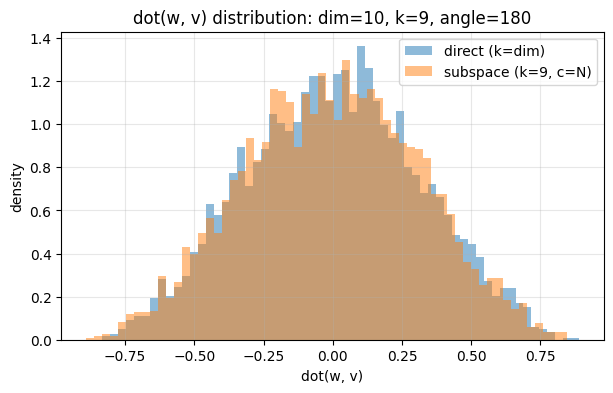

Means (should be ~0): 0.0026355698 -0.0033104583
Stds: 0.3120944 0.31418383
KS test: KstestResult(statistic=np.float64(0.0185546875), pvalue=np.float64(0.4811639497477914), statistic_location=np.float32(-0.1540798), statistic_sign=np.int8(-1))


In [ ]:
# Diagnostic: compare distributions via dot(w, v)
# Case A: direct uniform on S^{dim-1} (k=dim, angle=180)
# Case B: k=intrinsic_dim < dim with one fresh random subspace per sample (c=n), angle=180
import os, sys, math, time
import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), "src"))
import dataset_utils

# Params
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dim = 10
intrinsic_dim = 9   # change to 8 to test k=8
N = 4096            # number of samples per distribution
angle_deg = 180     # full sphere; change to <180 to see cap behavior
gaussianize = False
print(f"Device: {device}, dim={dim}, k={intrinsic_dim}, N={N}, angle={angle_deg}")

# Fixed random unit vector v
gen = torch.Generator(device=device)
gen.manual_seed(0)
v = torch.randn(dim, generator=gen, device=device)
v = v / v.norm()

# A) Direct uniform samples on S^{dim-1}
t0 = time.time()
w_full = dataset_utils.sample_cone(
    n=N, d=dim, max_theta=math.radians(angle_deg),
    min_theta=0.0, r=1.0, gaussianize=gaussianize, device=device
)
dp_full = torch.matmul(w_full, v).detach().cpu().numpy()
print(f"A) sampled in {time.time()-t0:.2f}s")

# B) Intrinsic sampling with fresh random subspace per sample (c = N)
#    This constructs N random k-d subspaces and draws one vector in each.
t0 = time.time()
w_sub, _ = dataset_utils.sample_cone_on_subspace(
    n=N, dim=dim, intrinsic_dim=intrinsic_dim,
    max_theta=math.radians(angle_deg), min_theta=0.0,
    basis=None, c=N, gaussianize=gaussianize, device=device
)
dp_sub = torch.matmul(w_sub, v).detach().cpu().numpy()
print(f"B) sampled in {time.time()-t0:.2f}s")

# Plot histograms
bins = 60
plt.figure(figsize=(7,4))
plt.hist(dp_full, bins=bins, density=True, alpha=0.5, label='direct (k=dim)')
plt.hist(dp_sub,  bins=bins, density=True, alpha=0.5, label=f'subspace (k={intrinsic_dim}, c=N)')
plt.xlabel('dot(w, v)')
plt.ylabel('density')
plt.title(f'dot(w, v) distribution: dim={dim}, k={intrinsic_dim}, angle={angle_deg}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Optional: simple statistics
print("Means (should be ~0):", np.mean(dp_full), np.mean(dp_sub))
print("Stds:", np.std(dp_full), np.std(dp_sub))

# Optional: KS test (requires scipy)
try:
    from scipy.stats import ks_2samp
    ks = ks_2samp(dp_full, dp_sub)
    print("KS test:", ks)
except Exception as e:
    print("KS test skipped (scipy not available):", e)

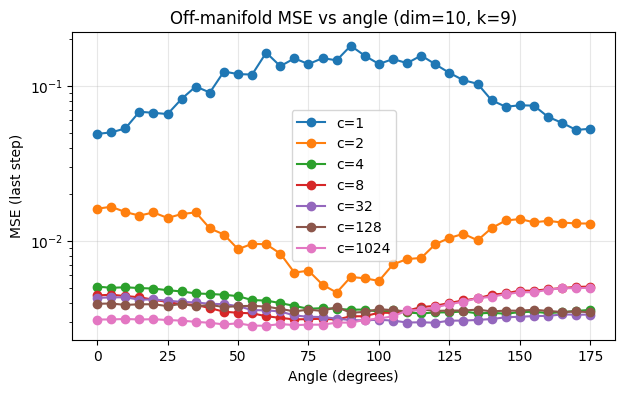

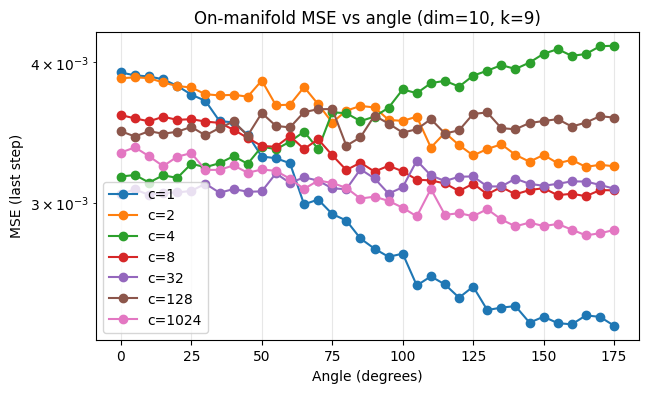

In [ ]:
# Plot angle-sweep MSE (same as first graph) for varying c, loading from output_dir
import os, numpy as np, matplotlib.pyplot as plt

# Config — set to match how you trained/saved
results_dir = "/content/drive/MyDrive/OOD_ICL_182"         # base dir if you prefixed paths; otherwise "."
dim = 10
intrinsic_dim = 9          # change to 8 to plot k=8
c_values = [1, 2, 4, 8,32,128,1024]
angle_deg = 180            # must match 'angle' used during training
pretrain_size = 2**10      # must match training
task = int(np.log2(pretrain_size))

# Angle sweep grid used by eval (must match defaults in eval_utils.test_cone_falloff)
start_angle, end_angle, strip_width = 0, 180, 5
angles = list(range(start_angle, end_angle, strip_width))

def off_path(c):
    return f"{results_dir}/output/d{dim}_k{intrinsic_dim}_c{c}/losses_angle{angle_deg}_tasks{task}.npy"

def on_path(c):
    return f"{results_dir}/output/d{dim}_k{intrinsic_dim}_c{c}/losses_manifold_angle{angle_deg}_tasks{task}.npy"

# Off-manifold plot (same as first graph)
plt.figure(figsize=(7,4))
for c in c_values:
    fp = off_path(c)
    if not os.path.exists(fp):
        print(f"Missing: {fp}")
        continue
    losses = np.load(fp)
    if len(losses) != len(angles):
        print(f"Warning: angle grid mismatch for c={c}: {len(losses)} vs {len(angles)}")
    plt.plot(angles[:len(losses)], losses, marker='o', label=f'c={c}')
plt.yscale('log')
plt.xlabel('Angle (degrees)')
plt.ylabel('MSE (last step)')
plt.title(f'Off-manifold MSE vs angle (dim={dim}, k={intrinsic_dim})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# On-manifold plot (if available)
plt.figure(figsize=(7,4))
have_any = False
for c in c_values:
    fp = on_path(c)
    if not os.path.exists(fp):
        continue
    losses = np.load(fp)
    have_any = True
    plt.plot(angles[:len(losses)], losses, marker='o', label=f'c={c}')
if have_any:
    plt.yscale('log')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('MSE (last step)')
    plt.title(f'On-manifold MSE vs angle (dim={dim}, k={intrinsic_dim})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print("No on-manifold files found; skipping on-manifold plot.")

using flash attention
using flash attention
using flash attention
using flash attention
c=1 -> (last step): 1.502236e-01
c=1 -> (last step): 2.842340e-01
c=1 -> (last step): 6.549328e-01
c=1 -> (last step): 8.023776e-01
using flash attention
using flash attention
using flash attention
using flash attention
c=2 -> (last step): 7.779591e-03
c=2 -> (last step): 1.766400e-02
c=2 -> (last step): 4.270446e-01
c=2 -> (last step): 7.075409e-01
using flash attention
using flash attention
using flash attention
using flash attention
c=4 -> (last step): 3.696766e-03
c=4 -> (last step): 3.957122e-03
c=4 -> (last step): 5.252684e-02
c=4 -> (last step): 4.127867e-01
using flash attention
using flash attention
using flash attention
using flash attention
c=8 -> (last step): 3.433225e-03
c=8 -> (last step): 2.911233e-03
c=8 -> (last step): 4.718812e-03
c=8 -> (last step): 1.204344e-01
using flash attention
using flash attention
using flash attention
using flash attention
c=32 -> (last step): 3.314020e-0

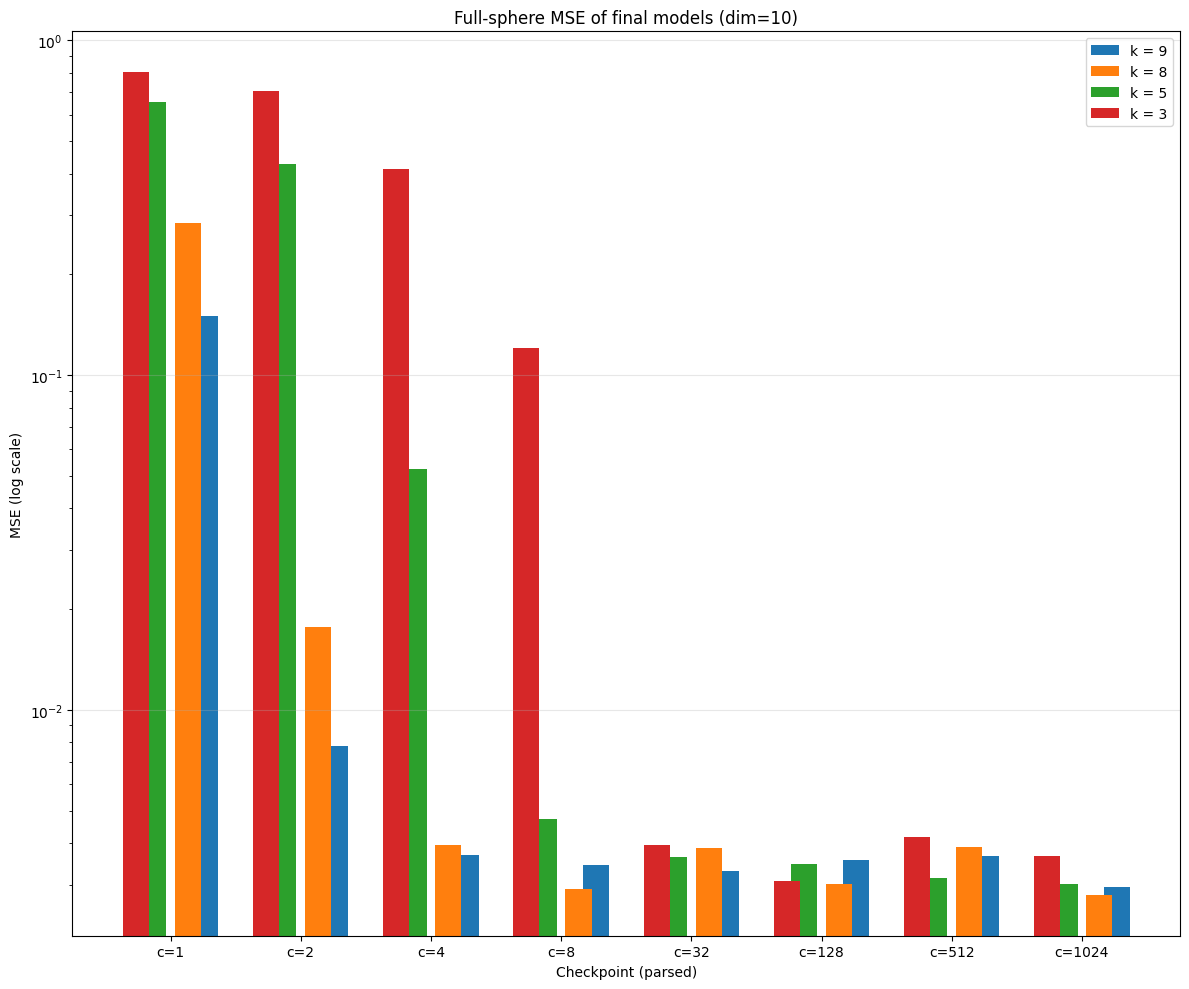

In [ ]:
# Recompute MSE of final model on 10D linear tasks (uniform over 10D sphere) and plot
import os, sys, re, torch, numpy as np, matplotlib.pyplot as plt
sys.path.append(os.path.join(os.getcwd(), "src"))

import transformer
import eval_utils

device = 'cuda' if torch.cuda.is_available() else 'cpu'

results_dir = "/content/drive/MyDrive/Jermaine_OOD_ICL_182"

# ==== Set these to match your run ====
dim = 10
seq_len = 50
d_model = 128
n_layer = 10

# Example checkpoint(s) to evaluate:
ckpt_paths1 = [
    f"{results_dir}/checkpoints/d10_k9_c1/final.th",
    f"{results_dir}/checkpoints/d10_k9_c2/final.th",
    f"{results_dir}/checkpoints/d10_k9_c4/final.th",
    f"{results_dir}/checkpoints/d10_k9_c8/final.th",
    f"{results_dir}/checkpoints/d10_k9_c32/final.th",
    f"{results_dir}/checkpoints/d10_k9_c128/final.th",
    f"{results_dir}/checkpoints/d10_k9_c512/final.th",
    f"{results_dir}/checkpoints/d10_k9_c1024/final.th"
]
ckpt_paths2 = [
    f"{results_dir}/checkpoints/d10_k8_c1/final.th",
    f"{results_dir}/checkpoints/d10_k8_c2/final.th",
    f"{results_dir}/checkpoints/d10_k8_c4/final.th",
    f"{results_dir}/checkpoints/d10_k8_c8/final.th",
    f"{results_dir}/checkpoints/d10_k8_c32/final.th",
    f"{results_dir}/checkpoints/d10_k8_c128/final.th",
    f"{results_dir}/checkpoints/d10_k8_c512/final.th",
    f"{results_dir}/checkpoints/d10_k8_c1024/final.th"
]
ckpt_paths3 = [
    f"{results_dir}/checkpoints/d10_k5_c1/final.th",
    f"{results_dir}/checkpoints/d10_k5_c2/final.th",
    f"{results_dir}/checkpoints/d10_k5_c4/final.th",
    f"{results_dir}/checkpoints/d10_k5_c8/final.th",
    f"{results_dir}/checkpoints/d10_k5_c32/final.th",
    f"{results_dir}/checkpoints/d10_k5_c128/final.th",
    f"{results_dir}/checkpoints/d10_k5_c512/final.th",
    f"{results_dir}/checkpoints/d10_k5_c1024/final.th"
]
ckpt_paths4 = [
    f"{results_dir}/checkpoints/d10_k3_c1/final.th",
    f"{results_dir}/checkpoints/d10_k3_c2/final.th",
    f"{results_dir}/checkpoints/d10_k3_c4/final.th",
    f"{results_dir}/checkpoints/d10_k3_c8/final.th",
    f"{results_dir}/checkpoints/d10_k3_c32/final.th",
    f"{results_dir}/checkpoints/d10_k3_c128/final.th",
    f"{results_dir}/checkpoints/d10_k3_c512/final.th",
    f"{results_dir}/checkpoints/d10_k3_c1024/final.th"
]




# Eval settings (match training defaults)
batch_size = 128
batches_per_epoch = 100
test_batches = 50
noise_std = 0.0
gaussianize = False  # => norm=True below

criterion = torch.nn.MSELoss()
grad_idxs = np.array(list(range(0, 2*seq_len, 2)))  # same mask used during training

def load_model(ckpt_path):
    model = transformer.RegressionTransformer(
        d_model=d_model, device=device, block_size=seq_len*2, n_layer=n_layer, input_dim=dim
    ).to(device)
    sd = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(sd)
    model.eval()
    return model

def compute_full_sphere_mse(model, lastonly=False, offset=12345):
    # ws=None + norm=True => weights normalized to unit sphere in 10D
    return eval_utils.test_model(
        model=model,
        device=device,
        grad_idxs=grad_idxs,
        criterion=criterion,
        epoch=1,
        dim=dim,
        batch_size=batch_size,
        batches_per_epoch=batches_per_epoch,
        seq_len=seq_len,
        noise_std=noise_std,
        offset=offset,
        test_batches=test_batches,
        ws=None,
        norm=(not gaussianize),
        lastonly=lastonly
    )

labels1, labels2, labels3, labels4, mse_last_list1, mse_last_list2, mse_last_list3, mse_last_list4 = [], [], [], [], [], [], [], []

for i in range(len(ckpt_paths1)):
    if not os.path.exists(ckpt_paths1[i]):
        print(f"Missing checkpoint: {ckpt_paths1[i]}")
        continue
    # Try to extract c (and k) from path for cleaner labels
    base1 = os.path.dirname(ckpt_paths1[i])
    base2 = os.path.dirname(ckpt_paths2[i])
    base3 = os.path.dirname(ckpt_paths3[i])
    base4 = os.path.dirname(ckpt_paths4[i])
    m_c1 = re.search(r"_c(\d+)", base1)
    m_k1 = re.search(r"_k(\d+)", base1)
    m_c2 = re.search(r"_c(\d+)", base2)
    m_k2 = re.search(r"_k(\d+)", base2)
    m_c3 = re.search(r"_c(\d+)", base3)
    m_k3 = re.search(r"_k(\d+)", base3)
    m_c4 = re.search(r"_c(\d+)", base4)
    m_k4 = re.search(r"_k(\d+)", base4)
    label1 = base1
    label2 = base2
    label3 = base3
    label4 = base4
    if m_c1:
        label1 = f"c={m_c1.group(1)}"
    else:
        label1 = os.path.basename(base1)
    if m_c2:
        label2 = f"c={m_c2.group(1)}"
    else:
        label2 = os.path.basename(base2)
    if m_c3:
        label3 = f"c={m_c3.group(1)}"
    else:
        label3 = os.path.basename(base3)
    if m_c4:
        label4 = f"c={m_c4.group(1)}"
    else:
        label4 = os.path.basename(base4)

    model1 = load_model(ckpt_paths1[i])
    model2 = load_model(ckpt_paths2[i])
    model3 = load_model(ckpt_paths3[i])
    model4 = load_model(ckpt_paths4[i])
    #mse_all = compute_full_sphere_mse(model, lastonly=False)
    mse_last1 = compute_full_sphere_mse(model1, lastonly=True)
    mse_last2 = compute_full_sphere_mse(model2, lastonly=True)
    mse_last3 = compute_full_sphere_mse(model3, lastonly=True)
    mse_last4 = compute_full_sphere_mse(model4, lastonly=True)
    print(f"{label1} -> (last step): {mse_last1:.6e}")
    print(f"{label2} -> (last step): {mse_last2:.6e}")
    print(f"{label3} -> (last step): {mse_last3:.6e}")
    print(f"{label4} -> (last step): {mse_last4:.6e}")
    labels1.append(label1)
    labels2.append(label2)
    labels3.append(label3)
    labels4.append(label4)
    #mse_all_list.append(mse_all)
    mse_last_list1.append(mse_last1)
    mse_last_list2.append(mse_last2)
    mse_last_list3.append(mse_last3)
    mse_last_list4.append(mse_last4)

# Plot
x = np.arange(len(labels1))
width = 0.2

plt.figure(figsize=(12,10))
plt.bar(x + width * 4 / 3 , mse_last_list1, width, label='k = 9')
plt.bar(x + width * 2 /3 , mse_last_list2, width, label='k = 8')
plt.bar(x - width * 2 /3, mse_last_list3, width, label='k = 5')
plt.bar(x - width  * 4 /3, mse_last_list4, width, label='k = 3')
plt.yscale('log')
plt.ylabel('MSE (log scale)')
plt.xlabel('Checkpoint (parsed)')
plt.title('Full-sphere MSE of final models (dim=10)')
plt.xticks(x, labels1, rotation=0)
plt.grid(True, axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Train: dim=10, k=9, c=8, angles in {120, 135, 150, 165}
import os, sys, time, torch, numpy as np, matplotlib.pyplot as plt
sys.path.append(os.path.join(os.getcwd(), "src"))

import train_linreg

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# Core settings
dim = 10
intrinsic_dim = 9
c = 8
angles_deg = [120, 135, 150, 165]  # half-angles (degrees)

results_dir = "/content/drive/MyDrive/OOD_ICL_182"

# Training hyperparams (adjust if needed)
batch_size = 128
lr = 3e-4
epochs = 120              # reduce if needed
batches_per_epoch = 100
seq_len = 50
d_model = 128
n_layer = 10
noise_std = 0.0
pretrain_size = 2**10
gaussianize = False
lr_milestones = []

final_test_mse = {}

for phi in angles_deg:
    ckpt_dir = f"{results_dir}/checkpoints/d{dim}_k{intrinsic_dim}_c{c}_angle{phi}/"
    out_dir  = f"{results_dir}/output/d{dim}_k{intrinsic_dim}_c{c}_angle{phi}/"

    print(f"\n=== Training: dim={dim}, k={intrinsic_dim}, c={c}, angle={phi}° ===")
    t0 = time.time()
    _, _, test_loss_hist, _, _ = train_linreg.train(
        batch_size=batch_size,
        lr=lr,
        epochs=epochs,
        batches_per_epoch=batches_per_epoch,
        device=device,
        seq_len=seq_len,
        d_model=d_model,
        n_layer=n_layer,
        dim=dim,
        noise_std=noise_std,
        c=c,
        checkpoint_dir=ckpt_dir,
        pretrain_size=pretrain_size,
        angle=phi,                 # train() converts to radians internally
        lr_milestones=lr_milestones,
        gaussianize=gaussianize,
        save_freq=3,
        output_dir=out_dir,
        intrinsic_dim=intrinsic_dim
    )
    elapsed = (time.time() - t0)/60
    final_mse = float(test_loss_hist[-1])
    final_test_mse[phi] = final_mse
    print(f"Done angle={phi}° in {elapsed:.2f} min | final test MSE: {final_mse:.6e}")

print("\nFinal test MSE by angle:", final_test_mse)

# Plot final test MSE vs angle
angles_sorted = sorted(final_test_mse.keys())
mses = [final_test_mse[a] for a in angles_sorted]

plt.figure(figsize=(6,4))
plt.plot(angles_sorted, mses, marker='o')
plt.xlabel('Half-angle (degrees)')
plt.ylabel('Final test MSE (full sphere, all steps)')
plt.title(f'Final test MSE vs pretraining angle (dim={dim}, k={intrinsic_dim}, c={c})')
plt.grid(True, alpha=0.3)
plt.show()

Device: cuda

=== Training: dim=10, k=9, c=8, angle=120° ===
Training on half-angle:  120
using flash attention
Epoch:  1
Epoch complete, time: 0.3828831712404887 minutes, loss: 0.9967114329338074, test loss: 1.0029125094413758
Epoch:  2
Epoch complete, time: 0.3346381743748983 minutes, loss: 0.9909522533416748, test loss: 0.9990898752212525
Epoch:  3
Epoch complete, time: 0.33670323292414345 minutes, loss: 1.0206316709518433, test loss: 1.0020040333271027
Epoch:  4
Epoch complete, time: 0.3582814892133077 minutes, loss: 0.9783439636230469, test loss: 1.0009673202037812
Epoch:  5
Epoch complete, time: 0.34667622248331703 minutes, loss: 0.9874153137207031, test loss: 1.0030170488357544
Epoch:  6
Epoch complete, time: 0.3488136649131775 minutes, loss: 1.0090044736862183, test loss: 0.9999800384044647
Epoch:  7
Epoch complete, time: 0.36585363149642947 minutes, loss: 1.020684838294983, test loss: 0.9998068630695343
Epoch:  8
Epoch complete, time: 0.34506576458613075 minutes, loss: 1.01242

In [ ]:
# Train sweeps: dim=10, ks={8,9}, c in {1,2,4,10}
results_dir = "/content/drive/MyDrive/Jermaine_OOD_ICL_182"
import os, sys, time, torch
sys.path.append(os.path.join(os.getcwd(), "src"))

import train_linreg

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

dim = 10
k = 5        # change to correct k value
c_values = [1,2,4,8,16]
angles = [30,60, 90, 120, 150] # Change angles to whichever one you said.
# Training hyperparams
batch_size = 128
lr = 3e-4
epochs = 120
batches_per_epoch = 100
seq_len = 50
d_model = 128
n_layer = 10
noise_std = 0.0
pretrain_size = 2**10
gaussianize = False
lr_milestones = []

mse_by_angle = {}  # {k: {c: final_test_mse}}
for angle in angles:
    mse_by_angle[angle] = {}
    for c in c_values:
        ckpt_dir = f"{results_dir}/checkpoints/d{dim}_k{k}_c{c}_angle{angle}/"
        out_dir  = f"{results_dir}/output/d{dim}_k{k}_c{c}_angle{angle}/"
        os.makedirs(ckpt_dir, exist_ok=True)
        os.makedirs(out_dir, exist_ok=True)
        print(f"\n=== Training: dim={dim}, k={k}, c={c}, angle={angle} ===")
        t0 = time.time()
        _, _, test_loss_hist, _, _ = train_linreg.train(
            batch_size=batch_size,
            lr=lr,
            epochs=epochs,
            batches_per_epoch=batches_per_epoch,
            device=device,
            seq_len=seq_len,
            d_model=d_model,
            n_layer=n_layer,
            dim=dim,
            noise_std=noise_std,
            c=c,
            checkpoint_dir=ckpt_dir,
            pretrain_size=pretrain_size,
            angle=angle,      # degrees -> radians inside train()
            lr_milestones=lr_milestones,
            gaussianize=gaussianize,
            save_freq=120,
            output_dir=out_dir,
            intrinsic_dim=k
        )
        final_mse = float(test_loss_hist[-1])
        mse_by_angle[angle][c] = final_mse
        print(f"Done in {(time.time()-t0)/60:.2f} min | final test MSE: {final_mse:.6f}")

print("\nCollected MSEs:", mse_by_angle)

Device: cuda

=== Training: dim=10, k=8, c=1, angle=90 ===
Training on half-angle:  90
using flash attention
Epoch:  1
Epoch complete, time: 0.25693125327428185 minutes, loss: 0.9465795755386353, test loss: 1.1086386036872864
Epoch:  2
Epoch complete, time: 0.21288878122965496 minutes, loss: 0.9298130869865417, test loss: 1.074500949382782
Epoch:  3
Epoch complete, time: 0.21292032400767008 minutes, loss: 0.9244443774223328, test loss: 1.080937488079071
Epoch:  4
Epoch complete, time: 0.21398872137069702 minutes, loss: 0.9181886315345764, test loss: 1.0864103293418885
Epoch:  5
Epoch complete, time: 0.21419231096903482 minutes, loss: 0.8931231498718262, test loss: 1.0810748791694642
Epoch:  6
Epoch complete, time: 0.2140540321667989 minutes, loss: 0.9291031956672668, test loss: 1.1010096549987793
Epoch:  7
Epoch complete, time: 0.21382011969884238 minutes, loss: 0.7163402438163757, test loss: 0.9383372867107391
Epoch:  8
Epoch complete, time: 0.21492969592412312 minutes, loss: 0.558782

Device: cuda
Skipping training, loading results for k=8...

Generating Heatmap...


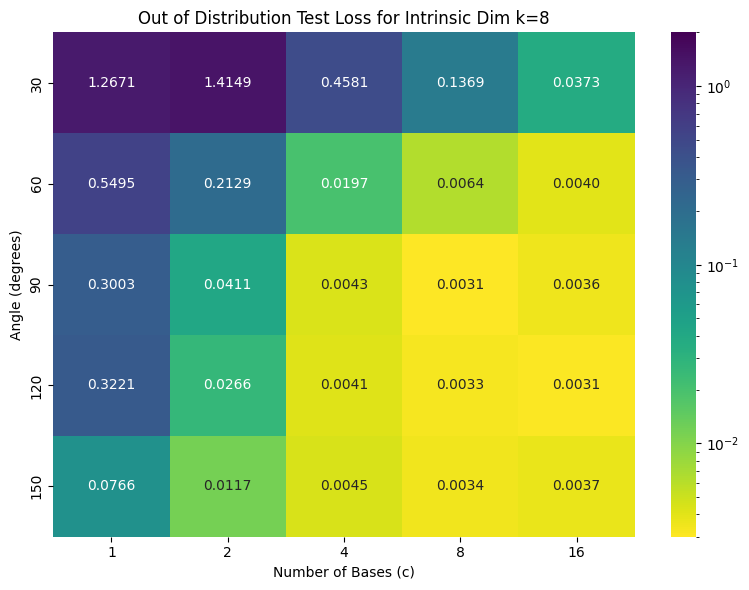


MSE Data Table:
[[1.26711621 1.41490561 0.45814241 0.13687564 0.03728144]
 [0.5494533  0.21287973 0.01972259 0.00639437 0.00398088]
 [0.30034136 0.04114868 0.00433899 0.0030701  0.00358182]
 [0.3221282  0.02664268 0.00408782 0.00325679 0.00311822]
 [0.07660654 0.01165014 0.00449656 0.00343641 0.00374055]]


In [ ]:
# Train sweeps: dim=10, ks={8,9}, c in {1,2,4,10}
results_dir = "/content/drive/MyDrive/Jermaine_OOD_ICL_182"
import os, sys, time, torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.join(os.getcwd(), "src"))

import train_linreg

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

dim = 10
# Configure the sweep
k_to_plot = 8         # The k dimension to visualize
c_values = [1,2,4,8,16]
angles = [30,60,90,120,150] # Full set of angles to consider

run_training = False    # Set to False to skip training and just generate plots from disk

# Training hyperparams
batch_size = 128
lr = 3e-4
epochs = 120
batches_per_epoch = 100
seq_len = 50
d_model = 128
n_layer = 10
noise_std = 0.0
pretrain_size = 2**10
gaussianize = False
lr_milestones = []

mse_data = {}  # {angle: {c: final_test_mse}}
task = int(np.log2(pretrain_size)) # Used in filename

if run_training:
    # Only train for the specified configuration (can be a subset if desired)
    # For the plot, we loop over all specified c_values and angles
    for angle in angles:
        mse_data[angle] = {}
        for c in c_values:
            ckpt_dir = f"{results_dir}/checkpoints/d{dim}_k{k_to_plot}_c{c}_angle{angle}/"
            out_dir  = f"{results_dir}/output/d{dim}_k{k_to_plot}_c{c}_angle{angle}/"
            os.makedirs(ckpt_dir, exist_ok=True)
            os.makedirs(out_dir, exist_ok=True)

            print(f"\n=== Training: dim={dim}, k={k_to_plot}, c={c}, angle={angle} ===")
            t0 = time.time()
            # train returns: model, loss_history, test_loss_history, angles, losses
            # We want the 5th return value: losses (from test_cone_falloff)
            _, _, _, falloff_angles, falloff_losses = train_linreg.train(
                batch_size=batch_size,
                lr=lr,
                epochs=epochs,
                batches_per_epoch=batches_per_epoch,
                device=device,
                seq_len=seq_len,
                d_model=d_model,
                n_layer=n_layer,
                dim=dim,
                noise_std=noise_std,
                c=c,
                checkpoint_dir=ckpt_dir,
                pretrain_size=pretrain_size,
                angle=angle,
                lr_milestones=lr_milestones,
                gaussianize=gaussianize,
                save_freq=120,
                output_dir=out_dir,
                intrinsic_dim=k_to_plot
            )

            # Find the loss corresponding to the training angle (ID performance)
            # The falloff test sweeps 0..180 with strip_width=5 (default in train_linreg.py)
            # We look for the closest angle in falloff_angles to our training angle
            closest_idx = np.argmin(np.abs(np.array(falloff_angles) - angle))
            id_loss = falloff_losses[closest_idx]

            mse_data[angle][c] = float(id_loss)
            print(f"Done in {(time.time()-t0)/60:.2f} min | ID Test Loss (at {falloff_angles[closest_idx]} deg): {id_loss:.6f}")
else:
    print(f"Skipping training, loading results for k={k_to_plot}...")
    for angle in angles:
        mse_data[angle] = {}
        for c in c_values:
            # Construct path to output file
            # train_linreg saves to: output_dir + "losses_angle{0}_tasks{1}.npy"
            out_dir  = f"{results_dir}/output/d{dim}_k{k_to_plot}_c{c}_angle{angle}/"
            filename = f"losses_angle{angle}_tasks{task}.npy"
            file_path = os.path.join(out_dir, filename)

            if os.path.exists(file_path):
                # This file contains the array of losses across angles 0..180
                falloff_losses = np.load(file_path)

                # Reconstruct the angle sweep array (same defaults as train_linreg)
                # start_angle=0, end_angle=180, strip_width=5
                falloff_angles = np.arange(0, 180, 5)

                if len(falloff_losses) != len(falloff_angles):
                     # Fallback if size mismatch (e.g. if params changed)
                     print(f"Warning: Size mismatch for {filename}, using last value")
                     mse_data[angle][c] = float(falloff_losses[-1])
                else:
                    closest_idx = np.argmin(np.abs(falloff_angles - angle))
                    id_loss = falloff_losses[closest_idx]
                    mse_data[angle][c] = float(id_loss)
            else:
                print(f"Warning: Missing result file at {file_path}")
                mse_data[angle][c] = np.nan

# --- Plotting the Heatmap ---
print("\nGenerating Heatmap...")

# Prepare grid
# Rows: angles, Cols: c_values
grid = np.zeros((len(angles), len(c_values)))

for i, ang in enumerate(angles):
    for j, c in enumerate(c_values):
        grid[i, j] = mse_data.get(ang, {}).get(c, np.nan)
vmin = np.nanmin(grid)
vmax = np.nanmax(grid)
plt.figure(figsize=(8, 6))
# Annotate with values; formatting to 4 decimal places
ax = sns.heatmap(grid, annot=True, fmt=".4f", cmap="viridis_r",
                 xticklabels=c_values, yticklabels=angles, norm=LogNorm(vmin=0.003, vmax=2))
ax.set_xlabel("Number of Bases (c)")
ax.set_ylabel("Angle (degrees)")
ax.set_title(f"Out of Distribution Test Loss for Intrinsic Dim k={k_to_plot}")
plt.tight_layout()
plt.show()

print("\nMSE Data Table:")
print(grid)


In [24]:
# Recompute and Plot Full-Sphere MSE from Checkpoints (with Error Bars)
import os, sys, re, torch, numpy as np, matplotlib.pyplot as plt
sys.path.append(os.path.join(os.getcwd(), "src"))
import transformer
import eval_utils

results_dir = "/content/drive/MyDrive/Jermaine_OOD_ICL_182"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ==========================================
# CONFIGURATION
# ==========================================
dim = 10
seq_len = 50
d_model = 128
n_layer = 10
ks = [5, 8, 9]
c_values = [1, 2, 4, 8, 10, 16, 32, 128, 512, 1024]
train_angle = 180
num_runs = 5       # Number of times to run evaluation for error bars
# ==========================================

def load_model(ckpt_path):
    model = transformer.RegressionTransformer(
        d_model=d_model, device=device, block_size=seq_len*2, n_layer=n_layer, input_dim=dim
    ).to(device)
    sd = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(sd)
    model.eval()
    return model

def compute_full_sphere_mse(model, run_idx):
    # Vary offset by run_idx to ensure different data seeds
    offset_val = 12345 + run_idx * 1000

    criterion = torch.nn.MSELoss()
    grad_idxs = np.array(list(range(0, 2*seq_len, 2)))

    return eval_utils.test_model(
        model=model,
        device=device,
        grad_idxs=grad_idxs,
        criterion=criterion,
        epoch=1,
        dim=dim,
        batch_size=128,
        batches_per_epoch=100,
        seq_len=seq_len,
        noise_std=0.0,
        offset=offset_val, # Critical for non-determinism across runs
        test_batches=50,
        ws=None,           # Full sphere
        norm=True,
        lastonly=True
    )

mse_means = {k: [] for k in ks}
mse_stds = {k: [] for k in ks}

print(f"Evaluating models for ks={ks} and c_values={c_values} over {num_runs} runs...")

for k in ks:
    for c in c_values:
        run_vals = []

        # 1. Try new folder structure
        ckpt_dir = f"{results_dir}/checkpoints/d{dim}_k{k}_c{c}_angle{train_angle}"
        ckpt_path = os.path.join(ckpt_dir, "final.th")

        if not os.path.exists(ckpt_path):
             # 2. Fallback to old folder structure
             ckpt_dir = f"{results_dir}/checkpoints/d{dim}_k{k}_c{c}"
             ckpt_path = os.path.join(ckpt_dir, "final.th")

        if os.path.exists(ckpt_path):
            try:
                model = load_model(ckpt_path)
                # Run multiple times
                for r in range(num_runs):
                    val = compute_full_sphere_mse(model, r)
                    run_vals.append(val)
            except Exception as e:
                print(f"Error evaluating {ckpt_path}: {e}")
        else:
            # Checkpoint missing
            pass

        if len(run_vals) > 0:
            mse_means[k].append(np.mean(run_vals))
            mse_stds[k].append(np.std(run_vals))
        else:
            mse_means[k].append(np.nan)
            mse_stds[k].append(np.nan)



Evaluating models for ks=[5, 8, 9] and c_values=[1, 2, 4, 8, 10, 16, 32, 128, 512, 1024] over 5 runs...
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention
using flash attention


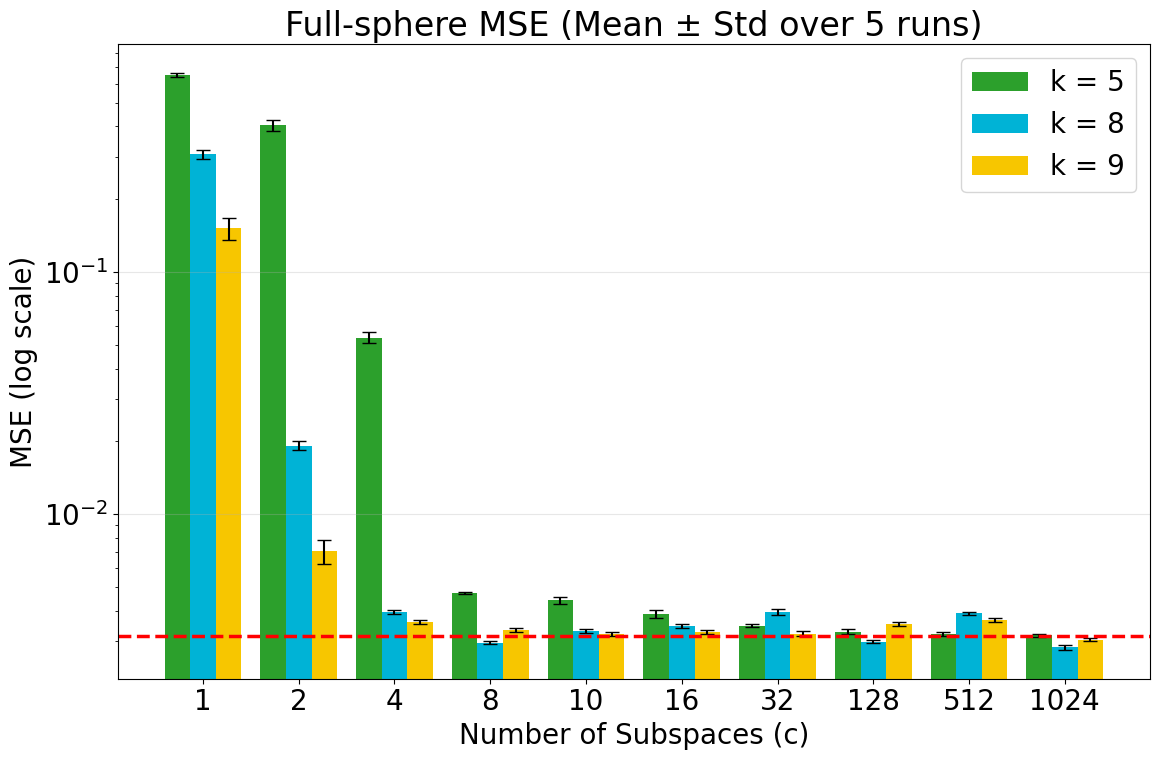

In [34]:
# Plotting
x = np.arange(len(c_values))
width = 0.8 / len(ks)
offsets = np.linspace(-(len(ks)-1)*width/2, (len(ks)-1)*width/2, len(ks))

plt.figure(figsize=(12, 8))
colors = ['#2ca02c', '#00B3D6', '#F7C600']
for i, k, in enumerate(ks):
    means = np.array(mse_means[k])
    stds = np.array(mse_stds[k])

    plt.bar(x + offsets[i], means, width, yerr=stds, capsize=5, label=f'k = {k}', color = colors[i])

baseline_value = 0.00315  # <- your number
plt.rcParams.update({'font.size': 20})
plt.yscale('log')
plt.ylabel('MSE (log scale)')
plt.xlabel('Number of Subspaces (c)')
plt.title(f'Full-sphere MSE (Mean ± Std over {num_runs} runs)')
plt.axhline(baseline_value, linestyle='--', color='red', linewidth=2.5)
plt.xticks(x, c_values)
plt.grid(True, axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Device: cuda
Skipping training, loading results for k=9...

Generating Heatmap...


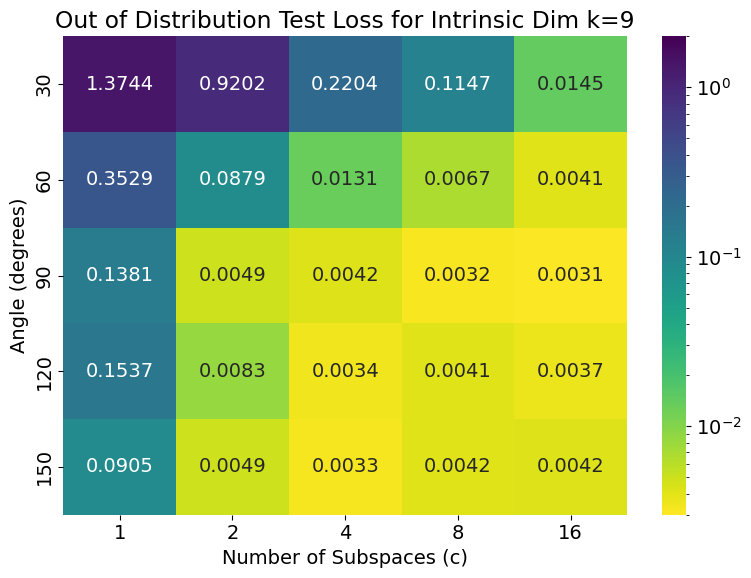


MSE Data Table:
[[1.37439766 0.92022164 0.2203658  0.11468472 0.01445687]
 [0.35285649 0.08789052 0.01312504 0.00673486 0.00412935]
 [0.13814486 0.00490184 0.00424882 0.0031859  0.00311923]
 [0.15374995 0.00833777 0.0034078  0.0041437  0.00366089]
 [0.09052787 0.00489827 0.00328412 0.00415825 0.00423038]]


In [39]:
# Train sweeps: dim=10, ks={8,9}, c in {1,2,4,10}
results_dir = "/content/drive/MyDrive/Jermaine_OOD_ICL_182"
import os, sys, time, torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
sys.path.append(os.path.join(os.getcwd(), "src"))

import train_linreg

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

dim = 10
# Configure the sweep
k_to_plot = 9      # The k dimension to visualize
c_values = [1,2,4,8,16]
angles = [30,60,90,120,150] # Full set of angles to consider

run_training = False    # Set to False to skip training and just generate plots from disk

# Training hyperparams
batch_size = 128
lr = 3e-4
epochs = 120
batches_per_epoch = 100
seq_len = 50
d_model = 128
n_layer = 10
noise_std = 0.0
pretrain_size = 2**10
gaussianize = False
lr_milestones = []

mse_data = {}  # {angle: {c: final_test_mse}}
task = int(np.log2(pretrain_size)) # Used in filename

if run_training:
    # Only train for the specified configuration (can be a subset if desired)
    # For the plot, we loop over all specified c_values and angles
    for angle in angles:
        mse_data[angle] = {}
        for c in c_values:
            ckpt_dir = f"{results_dir}/checkpoints/d{dim}_k{k_to_plot}_c{c}_angle{angle}/"
            out_dir  = f"{results_dir}/output/d{dim}_k{k_to_plot}_c{c}_angle{angle}/"
            os.makedirs(ckpt_dir, exist_ok=True)
            os.makedirs(out_dir, exist_ok=True)

            print(f"\n=== Training: dim={dim}, k={k_to_plot}, c={c}, angle={angle} ===")
            t0 = time.time()
            # train returns: model, loss_history, test_loss_history, angles, losses
            # We want the 5th return value: losses (from test_cone_falloff)
            _, _, _, falloff_angles, falloff_losses = train_linreg.train(
                batch_size=batch_size,
                lr=lr,
                epochs=epochs,
                batches_per_epoch=batches_per_epoch,
                device=device,
                seq_len=seq_len,
                d_model=d_model,
                n_layer=n_layer,
                dim=dim,
                noise_std=noise_std,
                c=c,
                checkpoint_dir=ckpt_dir,
                pretrain_size=pretrain_size,
                angle=angle,
                lr_milestones=lr_milestones,
                gaussianize=gaussianize,
                save_freq=120,
                output_dir=out_dir,
                intrinsic_dim=k_to_plot
            )

            # Find the loss corresponding to the training angle (ID performance)
            # The falloff test sweeps 0..180 with strip_width=5 (default in train_linreg.py)
            # We look for the closest angle in falloff_angles to our training angle
            closest_idx = np.argmin(np.abs(np.array(falloff_angles) - angle))
            id_loss = falloff_losses[closest_idx]

            mse_data[angle][c] = float(id_loss)
            print(f"Done in {(time.time()-t0)/60:.2f} min | ID Test Loss (at {falloff_angles[closest_idx]} deg): {id_loss:.6f}")
else:
    print(f"Skipping training, loading results for k={k_to_plot}...")
    for angle in angles:
        mse_data[angle] = {}
        for c in c_values:
            # Construct path to output file
            # train_linreg saves to: output_dir + "losses_angle{0}_tasks{1}.npy"
            out_dir  = f"{results_dir}/output/d{dim}_k{k_to_plot}_c{c}_angle{angle}/"
            filename = f"losses_angle{angle}_tasks{task}.npy"
            file_path = os.path.join(out_dir, filename)

            if os.path.exists(file_path):
                # This file contains the array of losses across angles 0..180
                falloff_losses = np.load(file_path)

                # Reconstruct the angle sweep array (same defaults as train_linreg)
                # start_angle=0, end_angle=180, strip_width=5
                falloff_angles = np.arange(0, 180, 5)

                if len(falloff_losses) != len(falloff_angles):
                     # Fallback if size mismatch (e.g. if params changed)
                     print(f"Warning: Size mismatch for {filename}, using last value")
                     mse_data[angle][c] = float(falloff_losses[-1])
                else:
                    closest_idx = np.argmin(np.abs(falloff_angles - angle))
                    id_loss = falloff_losses[closest_idx]
                    mse_data[angle][c] = float(id_loss)
            else:
                print(f"Warning: Missing result file at {file_path}")
                mse_data[angle][c] = np.nan
plt.rcParams.update({'font.size': 14})
# --- Plotting the Heatmap ---
print("\nGenerating Heatmap...")

# Prepare grid
# Rows: angles, Cols: c_values
grid = np.zeros((len(angles), len(c_values)))

for i, ang in enumerate(angles):
    for j, c in enumerate(c_values):
        grid[i, j] = mse_data.get(ang, {}).get(c, np.nan)
vmin = np.nanmin(grid)
vmax = np.nanmax(grid)
plt.figure(figsize=(8, 6))
# Annotate with values; formatting to 4 decimal places
ax = sns.heatmap(grid, annot=True, fmt=".4f", cmap="viridis_r",
                 xticklabels=c_values, yticklabels=angles, norm=LogNorm(vmin=0.003, vmax=2))
ax.set_xlabel("Number of Subspaces (c)")
ax.set_ylabel("Angle (degrees)")
ax.set_title(f"Out of Distribution Test Loss for Intrinsic Dim k={k_to_plot}")
plt.tight_layout()
plt.show()

print("\nMSE Data Table:")
print(grid)


In [ ]:
# Train sweeps focused on prompt length: fixed k and c grids, prompt lengths via CLI.
import argparse
import os
import sys
import time
import torch

# Ensure we can import the OOD_ICL src modules no matter the entry point.
repo_root = os.path.dirname(os.path.abspath(__file__))
src_path = os.path.join(repo_root, "OOD_ICL", "src")
if src_path not in sys.path:
    sys.path.append(src_path)

import train_linreg


def parse_args():
    parser = argparse.ArgumentParser(description="Sweep prompt lengths while fixing k and c grids.")
    parser.add_argument('--prompt_lens', type=int, nargs='+',
                        default=None,
                        help='Prompt lengths (seq_len) to sweep.')
    parser.add_argument('--device', type=str, default=None, help='Device string, e.g. cuda or cuda:0')
    return parser.parse_args()


def main():
    args = parse_args()
    device = args.device or ('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Fixed grids for k and c.
    ks = [2, 3, 5, 8]
    c_values = [1, 2, 4]

    # Fixed hyperparameters (edit here if needed).
    results_dir = "results4"
    dim = 10
    angle_deg = 180
    batch_size = 128
    lr = 3e-4
    epochs = 120
    batches_per_epoch = 100
    d_model = 128
    n_layer = 10
    noise_std = 0.0
    pretrain_size = 2**10
    gaussianize = False
    lr_milestones = []
    save_freq = 120  # reduce checkpoint churn across many runs

    prompt_lens = args.prompt_lens
    assert prompt_lens is not None, "prompts is none"

    mse_by_prompt = {}  # {prompt_len: {k: {c: final_test_mse}}}
    for prompt_len in prompt_lens:
        mse_by_prompt[prompt_len] = {}
        for k in ks:
            mse_by_prompt[prompt_len][k] = {}
            for c in c_values:
                ckpt_dir = f"{results_dir}/checkpoints/d{dim}_k{k}_c{c}_p{prompt_len}/"
                out_dir = f"{results_dir}/output/d{dim}_k{k}_c{c}_p{prompt_len}/"
                os.makedirs(ckpt_dir, exist_ok=True)
                os.makedirs(out_dir, exist_ok=True)
                print(f"\n=== Training: dim={dim}, k={k}, c={c}, prompt_len={prompt_len}, angle={angle_deg} ===")
                t0 = time.time()
                _, _, test_loss_hist, _, _ = train_linreg.train(
                    batch_size=batch_size,
                    lr=lr,
                    epochs=epochs,
                    batches_per_epoch=batches_per_epoch,
                    device=device,
                    seq_len=prompt_len,
                    d_model=d_model,
                    n_layer=n_layer,
                    dim=dim,
                    noise_std=noise_std,
                    c=c,
                    checkpoint_dir=ckpt_dir,
                    pretrain_size=pretrain_size,
                    angle=angle_deg,  # degrees -> radians inside train()
                    lr_milestones=lr_milestones,
                    gaussianize=gaussianize,
                    save_freq=save_freq,
                    output_dir=out_dir,
                    intrinsic_dim=k
                )
                final_mse = float(test_loss_hist[-1])
                mse_by_prompt[prompt_len][k][c] = final_mse
                print(f"Done in {(time.time()-t0)/60:.2f} min | final test MSE: {final_mse:.6f}")

    print("\nCollected MSEs:", mse_by_prompt)


if __name__ == "__main__":
    main()